In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [34]:
df = pd.DataFrame(dict(np.load('../psy-work/decision/result.npz')))

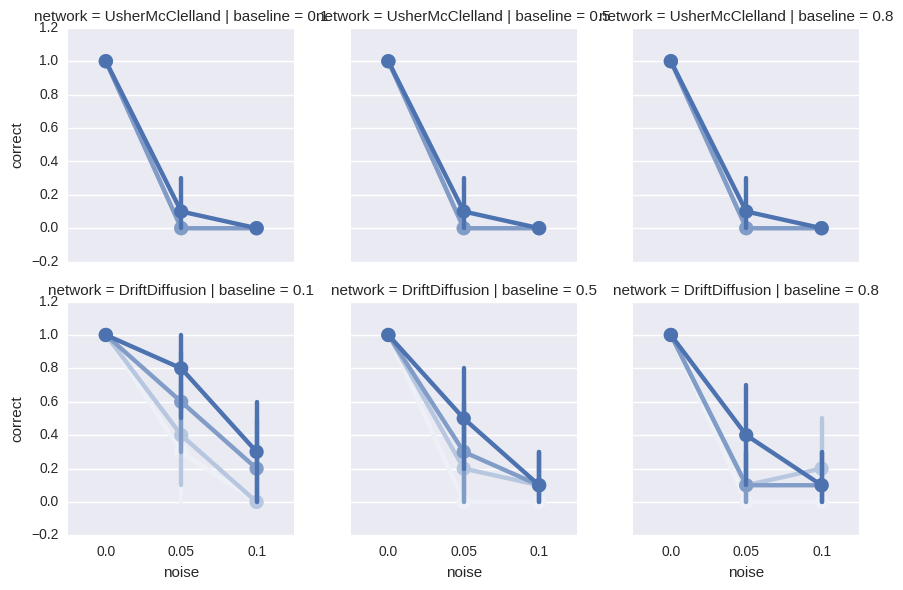

In [35]:
g = sns.FacetGrid(df, row='network', col='baseline')
g.map(sns.pointplot, 'noise', 'correct', 'target_sep')

In [24]:
df

,baseline,correct,network,noise,runnerup_err,runnerup_highest_err,seed,target_sep,winner_err
0,0.1,True,UsherMcClelland,0.00,0.000000,0.034233,0,0.05,0.485812
1,0.1,True,UsherMcClelland,0.00,0.000000,0.032608,2,0.15,0.853181
2,0.8,True,UsherMcClelland,0.00,0.000000,0.100150,8,0.05,0.463735
3,0.8,False,UsherMcClelland,0.10,0.483370,1.934155,5,0.05,-0.579157
4,0.1,True,UsherMcClelland,0.00,0.000000,0.029313,4,0.10,0.703402
5,0.1,True,UsherMcClelland,0.05,0.438459,1.438732,8,0.15,0.082686
6,0.8,True,UsherMcClelland,0.05,0.505869,1.504747,8,0.15,0.142049
7,0.5,True,UsherMcClelland,0.05,0.408217,1.409747,7,0.10,0.048480
8,0.1,True,UsherMcClelland,0.05,0.285464,1.654859,5,0.15,0.144695
9,0.5,True,UsherMcClelland,0.00,0.000000,0.060477,3,0.15,0.797524
